#### Importing The Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

#### Root data directory path

In [4]:
data_dir = '/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/data/'

#### Total number of classes

In [5]:
class_names = os.listdir(data_dir)
num_classes = len(class_names)
num_classes

2

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T, datasets

#### Checking CUDA availability

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


#### Transfroming the data

In [8]:
data_transform = T.Compose([
    T.Resize((224, 224)), # Resize the image to 224x224
    T.RandomRotation(degrees=(-20,+20)), # Randomly rotate the image by -20 to +20 degrees
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet mean and std
])

In [9]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
total_count = len(data)
print("Total count:", total_count)

Total count: 5232


In [10]:
data.classes

['NORMAL', 'PNEUMONIA']

#### Splitting the data

In [11]:
train_count = int(0.6 * total_count) # 60% of the total count
valid_count = int(0.3 * total_count) # 30% of the total count
test_count = total_count - train_count - valid_count # 10% of the total count
train_data, valid_data, test_data = torch.utils.data.random_split(data, [train_count, valid_count, test_count])

In [12]:
train_data.dataset

Dataset ImageFolder
    Number of datapoints: 5232
    Root location: /home/z4hid/gitpublicz4hid/x-ray-vision/notebook/data/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
len(train_data.indices)

3139

In [14]:
len(valid_data.indices)

1569

In [15]:
len(test_data.indices)

524

#### defining helper functions

In [16]:
def show_image(image, label, get_denormalize=True):
    
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    if get_denormalize == True:
        image = image * std + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(label)
    
    else:
        plt.imshow(image)
        plt.title(label)
        

def show_grid(image, title=None):
    
    image = image.pretuple(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        

def accuracy(y_pred, y_ture):
    y_pred = F.softmax(y_pred, dim=1)
    top_p,top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_ture.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

       

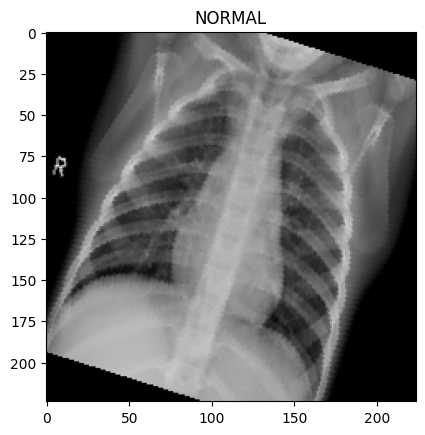

In [18]:
img, label = train_data[0]
show_image(img, class_names[label])

#### data Loaders

In [23]:
traindataloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in train dataloader:", len(traindataloader))
print("No. of Total Examples: ", len(traindataloader.dataset))

validationdataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
print("No. of batches in validation dataloader:", len(validationdataloader))
print("No. of Total Examples: ", len(validationdataloader.dataset))

testdataloader = DataLoader(test_data, batch_size=32, shuffle=False) # Shuffle is set to False
print("No. of batches in test dataloader:", len(testdataloader))
print("No. of Total Examples: ", len(testdataloader.dataset))


No. of batches in train dataloader: 99
No. of Total Examples:  3139
No. of batches in validation dataloader: 50
No. of Total Examples:  1569
No. of batches in test dataloader: 17
No. of Total Examples:  524


#### Model

In [26]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

In [30]:
model = models.resnet34(pretrained=True)

/home/z4hid/anaconda3/envs/aiagents/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z4hid/anaconda3/envs/aiagents/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [35]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, device):
    # Initialize variables to store total loss and correct predictions
    total_train_loss = 0
    total_val_loss = 0
    train_correct = 0
    val_correct = 0
    
    # Set model to training mode
    model.train()
    with tqdm(train_dataloader, unit="batch", leave=False) as pbar:
        pbar.set_description(f"Training")
        for images, idxs in pbar:
            # Move data to the specified device
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            
            # Forward pass
            output = model(images)
            
            # Compute loss
            loss = criterion(output, idxs)
            total_train_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(output, 1)
            train_correct += (predicted == idxs).sum().item()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for validation
        with tqdm(val_dataloader, unit="batch", leave=False) as pbar:
            pbar.set_description(f"Validation")
            for images, idxs in pbar:
                # Move data to the specified device
                images = images.to(device, non_blocking=True)
                idxs = idxs.to(device, non_blocking=True)
                
                # Forward pass
                output = model(images)
                
                # Compute loss
                loss = criterion(output, idxs)
                total_val_loss += loss.item()
                
                # Compute accuracy
                _, predicted = torch.max(output, 1)
                val_correct += (predicted == idxs).sum().item()
    
    # Calculate average loss and accuracy
    train_loss = total_train_loss / len(train_dataloader)
    val_loss = total_val_loss / len(val_dataloader)
    train_acc = train_correct / len(train_dataloader.dataset)
    val_acc = val_correct / len(val_dataloader.dataset)
    
    # Print results
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    return train_loss, train_acc, val_loss, val_acc

In [37]:
%%time
epochs = 5
for i in range(epochs):
    print(f"Epoch {i+1} of {epochs}")
    train(model, criterion, optimizer, traindataloader, validationdataloader, device)

Epoch 1 of 5


Train Loss: 0.0373, Train Accuracy: 0.9873, Val Loss: 0.0396, Val Accuracy: 0.9866
Epoch 2 of 5


Train Loss: 0.0779, Train Accuracy: 0.9892, Val Loss: 0.0480, Val Accuracy: 0.9834
Epoch 3 of 5


Train Loss: 0.0581, Train Accuracy: 0.9796, Val Loss: 0.0508, Val Accuracy: 0.9809
Epoch 4 of 5


Train Loss: 0.0260, Train Accuracy: 0.9904, Val Loss: 0.0741, Val Accuracy: 0.9700
Epoch 5 of 5


Train Loss: 0.0292, Train Accuracy: 0.9904, Val Loss: 0.0628, Val Accuracy: 0.9745
CPU times: user 18min 36s, sys: 3.22 s, total: 18min 39s
Wall time: 3min 44s


#### Model Saving

In [38]:
path = "/home/z4hid/gitpublicz4hid/x-ray-vision/notebook/model.pt"
torch.save(model, path)

#### Loading saved model

In [41]:
# Model class must be defined
model = torch.load(path, weights_only=False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Model Evaluation

In [ ]:
def evaluate(model, criterion, optimizer, test_dataloader):
    total_test_loss = 0
    
    model.eval()
    with tqdm(test_dataloader, unit="batch", leave=False) as pbar:
        pbar.set_description(f"Testing")
        for images, idxs in pbar:
            # Move data to the specified device
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            
            # Forward pass
            output = model(images)
            
            # Compute loss
            loss = criterion(output, idxs)
            total_test_loss += loss.item()
    
    test_acc = 1 - total_test_loss / len(test_dataloader)
    test_loss = total_test_loss / len(test_dataloader)
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")